# Exploring the BART ridership dataset

Source: https://www.bart.gov/about/reports/ridership

In [1]:
import torch
import numpy as np
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}

## Aggregate data

Let's load the data after running [preprocessing.py](https://github.com/pyro-ppl/sandbox/blob/master/2019-08-time-series/bart/preprocess.py).

In [2]:
from preprocess import load_hourly_od
dataset = load_hourly_od()
counts = dataset["counts"]
print(counts.shape)

torch.Size([70128, 47, 47])


In [28]:
print(dataset.keys())
print(dataset['start_date'])
print(dataset['start_date'][0].strftime('%A'))


dict_keys(['args', 'stations', 'start_date', 'counts'])
(datetime.datetime(2011, 1, 1, 0, 0),)
Saturday


Let's plot two weeks of total ride counts.

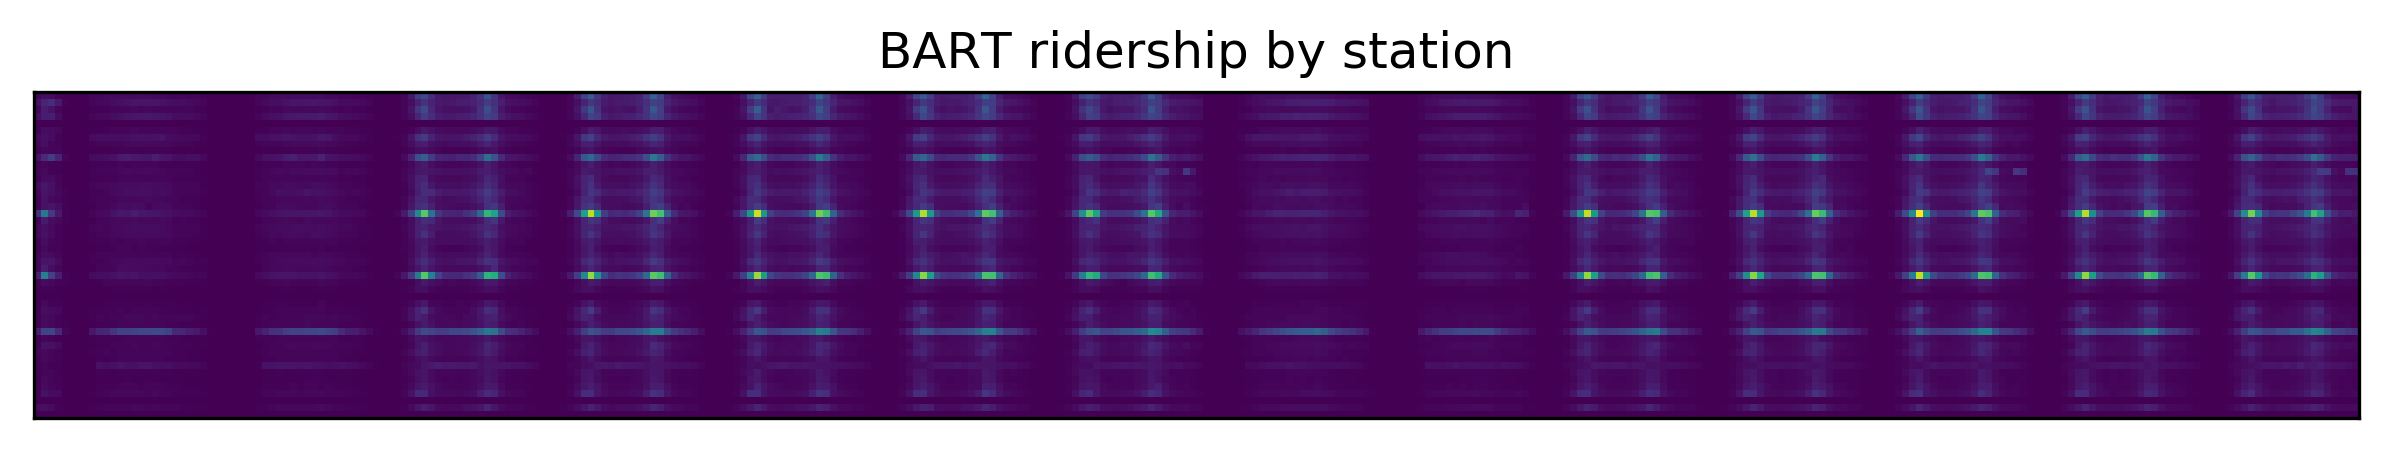

In [3]:
totals = counts.sum(-1) + counts.sum(-2)

pyplot.figure(figsize=(10,3), dpi=300)
pyplot.imshow(totals[:24 * 7 * 2, :].t().numpy())
pyplot.yticks([])
pyplot.xticks([])
pyplot.title("BART ridership by station");

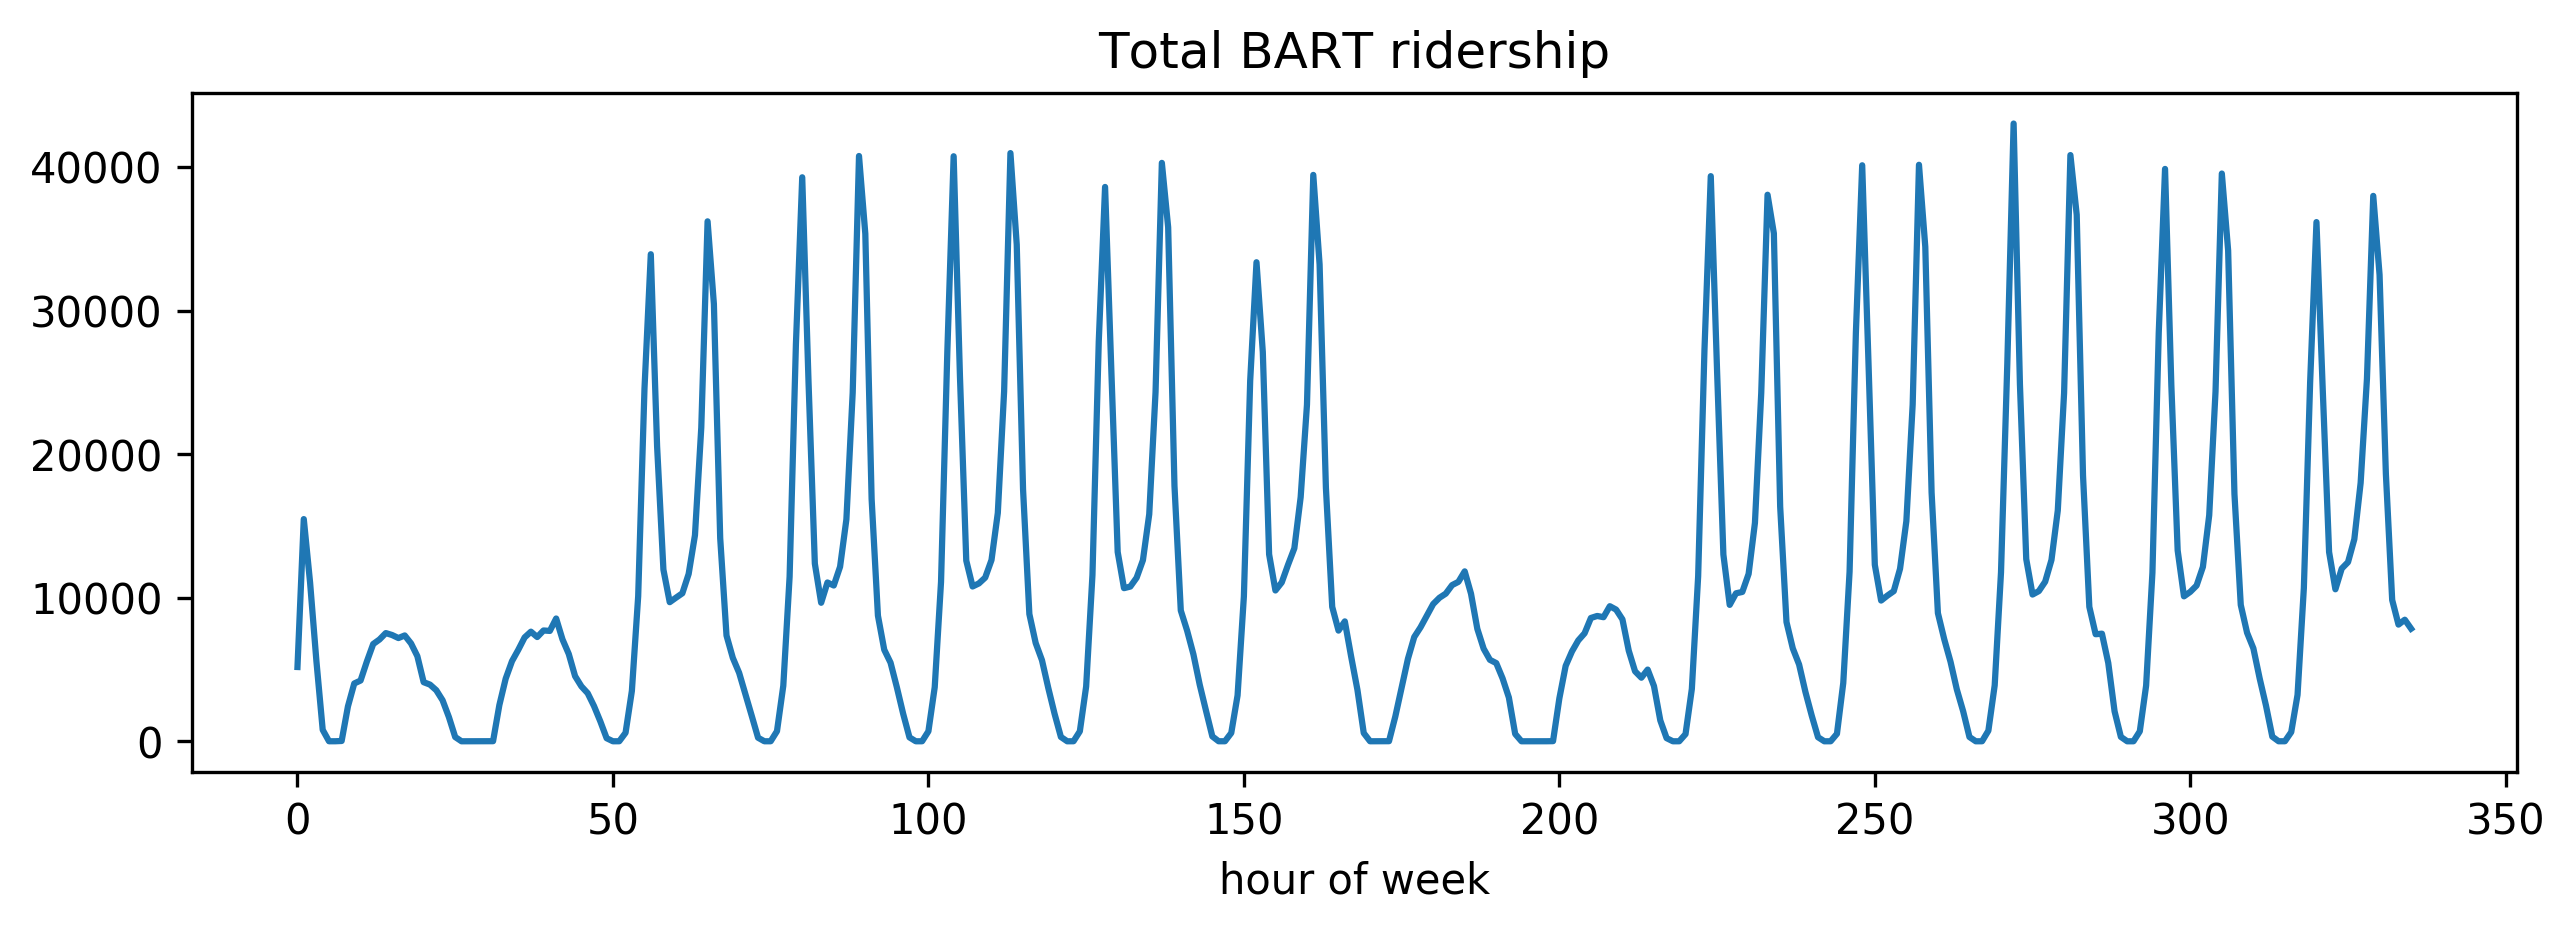

In [5]:
total = totals.sum(-1) / 2
pyplot.figure(figsize=(10, 3), dpi=300)
pyplot.plot(total[:24 * 7 * 2])
pyplot.xlabel("hour of week")
pyplot.title("Total BART ridership");

In [19]:
total = total[:len(total) // (24 * 7) * (24 * 7)]
total.reshape(-1, 24 * 7).max(0)[0].min(0)

torch.return_types.min(
values=tensor(774.),
indices=tensor(29))

Which stations see the most traffic?

In [5]:
total = dict(zip(dataset["stations"], totals.mean(0).numpy()))
ranked = sorted(dataset["stations"], key=total.__getitem__, reverse=True)
print("Riders/day Station")
for name in ranked:
    print("{: >10.1f} {}".format(total[name], name))

Riders/day Station
    2654.9 EMBR
    2563.7 MONT
    2242.5 POWL
    1538.4 CIVC
     902.0 24TH
     892.3 DBRK
     877.0 16TH
     868.5 12TH
     806.7 19TH
     805.9 BALB
     630.2 DALY
     607.1 MCAR
     568.5 FTVL
     562.8 DELN
     538.1 FRMT
     536.7 COLS
     522.7 GLEN
     518.3 DUBL
     505.9 SFIA
     472.2 WOAK
     468.5 LAKE
     453.6 PHIL
     450.7 WCRK
     434.3 MLBR
     398.0 PITT
     396.7 BAYF
     395.5 SANL
     395.4 CONC
     392.3 ROCK
     364.7 ASHB
     334.8 HAYW
     325.6 PLZA
     311.3 NBRK
     305.3 UCTY
     287.8 COLM
     282.8 RICH
     247.5 SBRN
     241.7 LAFY
     222.3 SSAN
     217.4 WDUB
     210.2 SHAY
     195.8 ORIN
     192.3 CAST
     167.4 NCON
      58.0 OAKL
      48.2 WSPR
      14.5 ANTI


## Control features

The model in [forecast.py](https://github.com/pyro-ppl/sandbox/blob/master/2019-08-time-series/bart/forecast.py) uses station open-closed state as a control feature, so we can ask causal quetsions and counterfactuals like "what would traffic have been like if station X had not closed yesterday".

In [6]:
metadata = torch.load("training.pkl")
control = metadata["control"].t().contiguous()

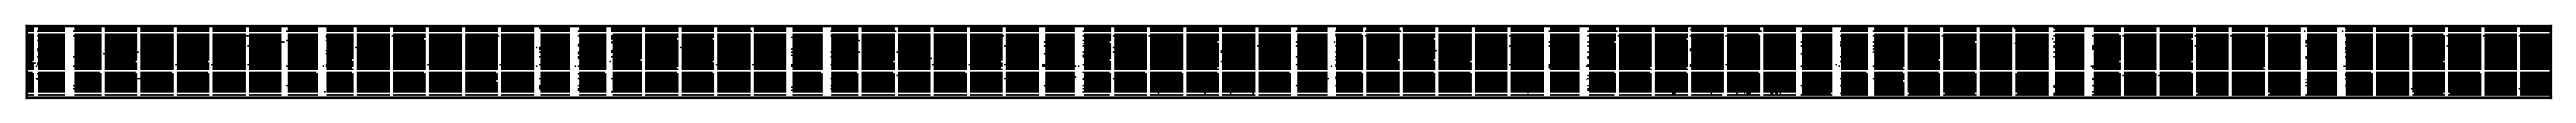

In [7]:
pyplot.figure(figsize=(14,3), dpi=300)
pyplot.imshow(control[:, :24 * 7 * 10].numpy(), cmap="binary")
pyplot.yticks([]); pyplot.xticks([]);

<Figure size 4200x900 with 0 Axes>

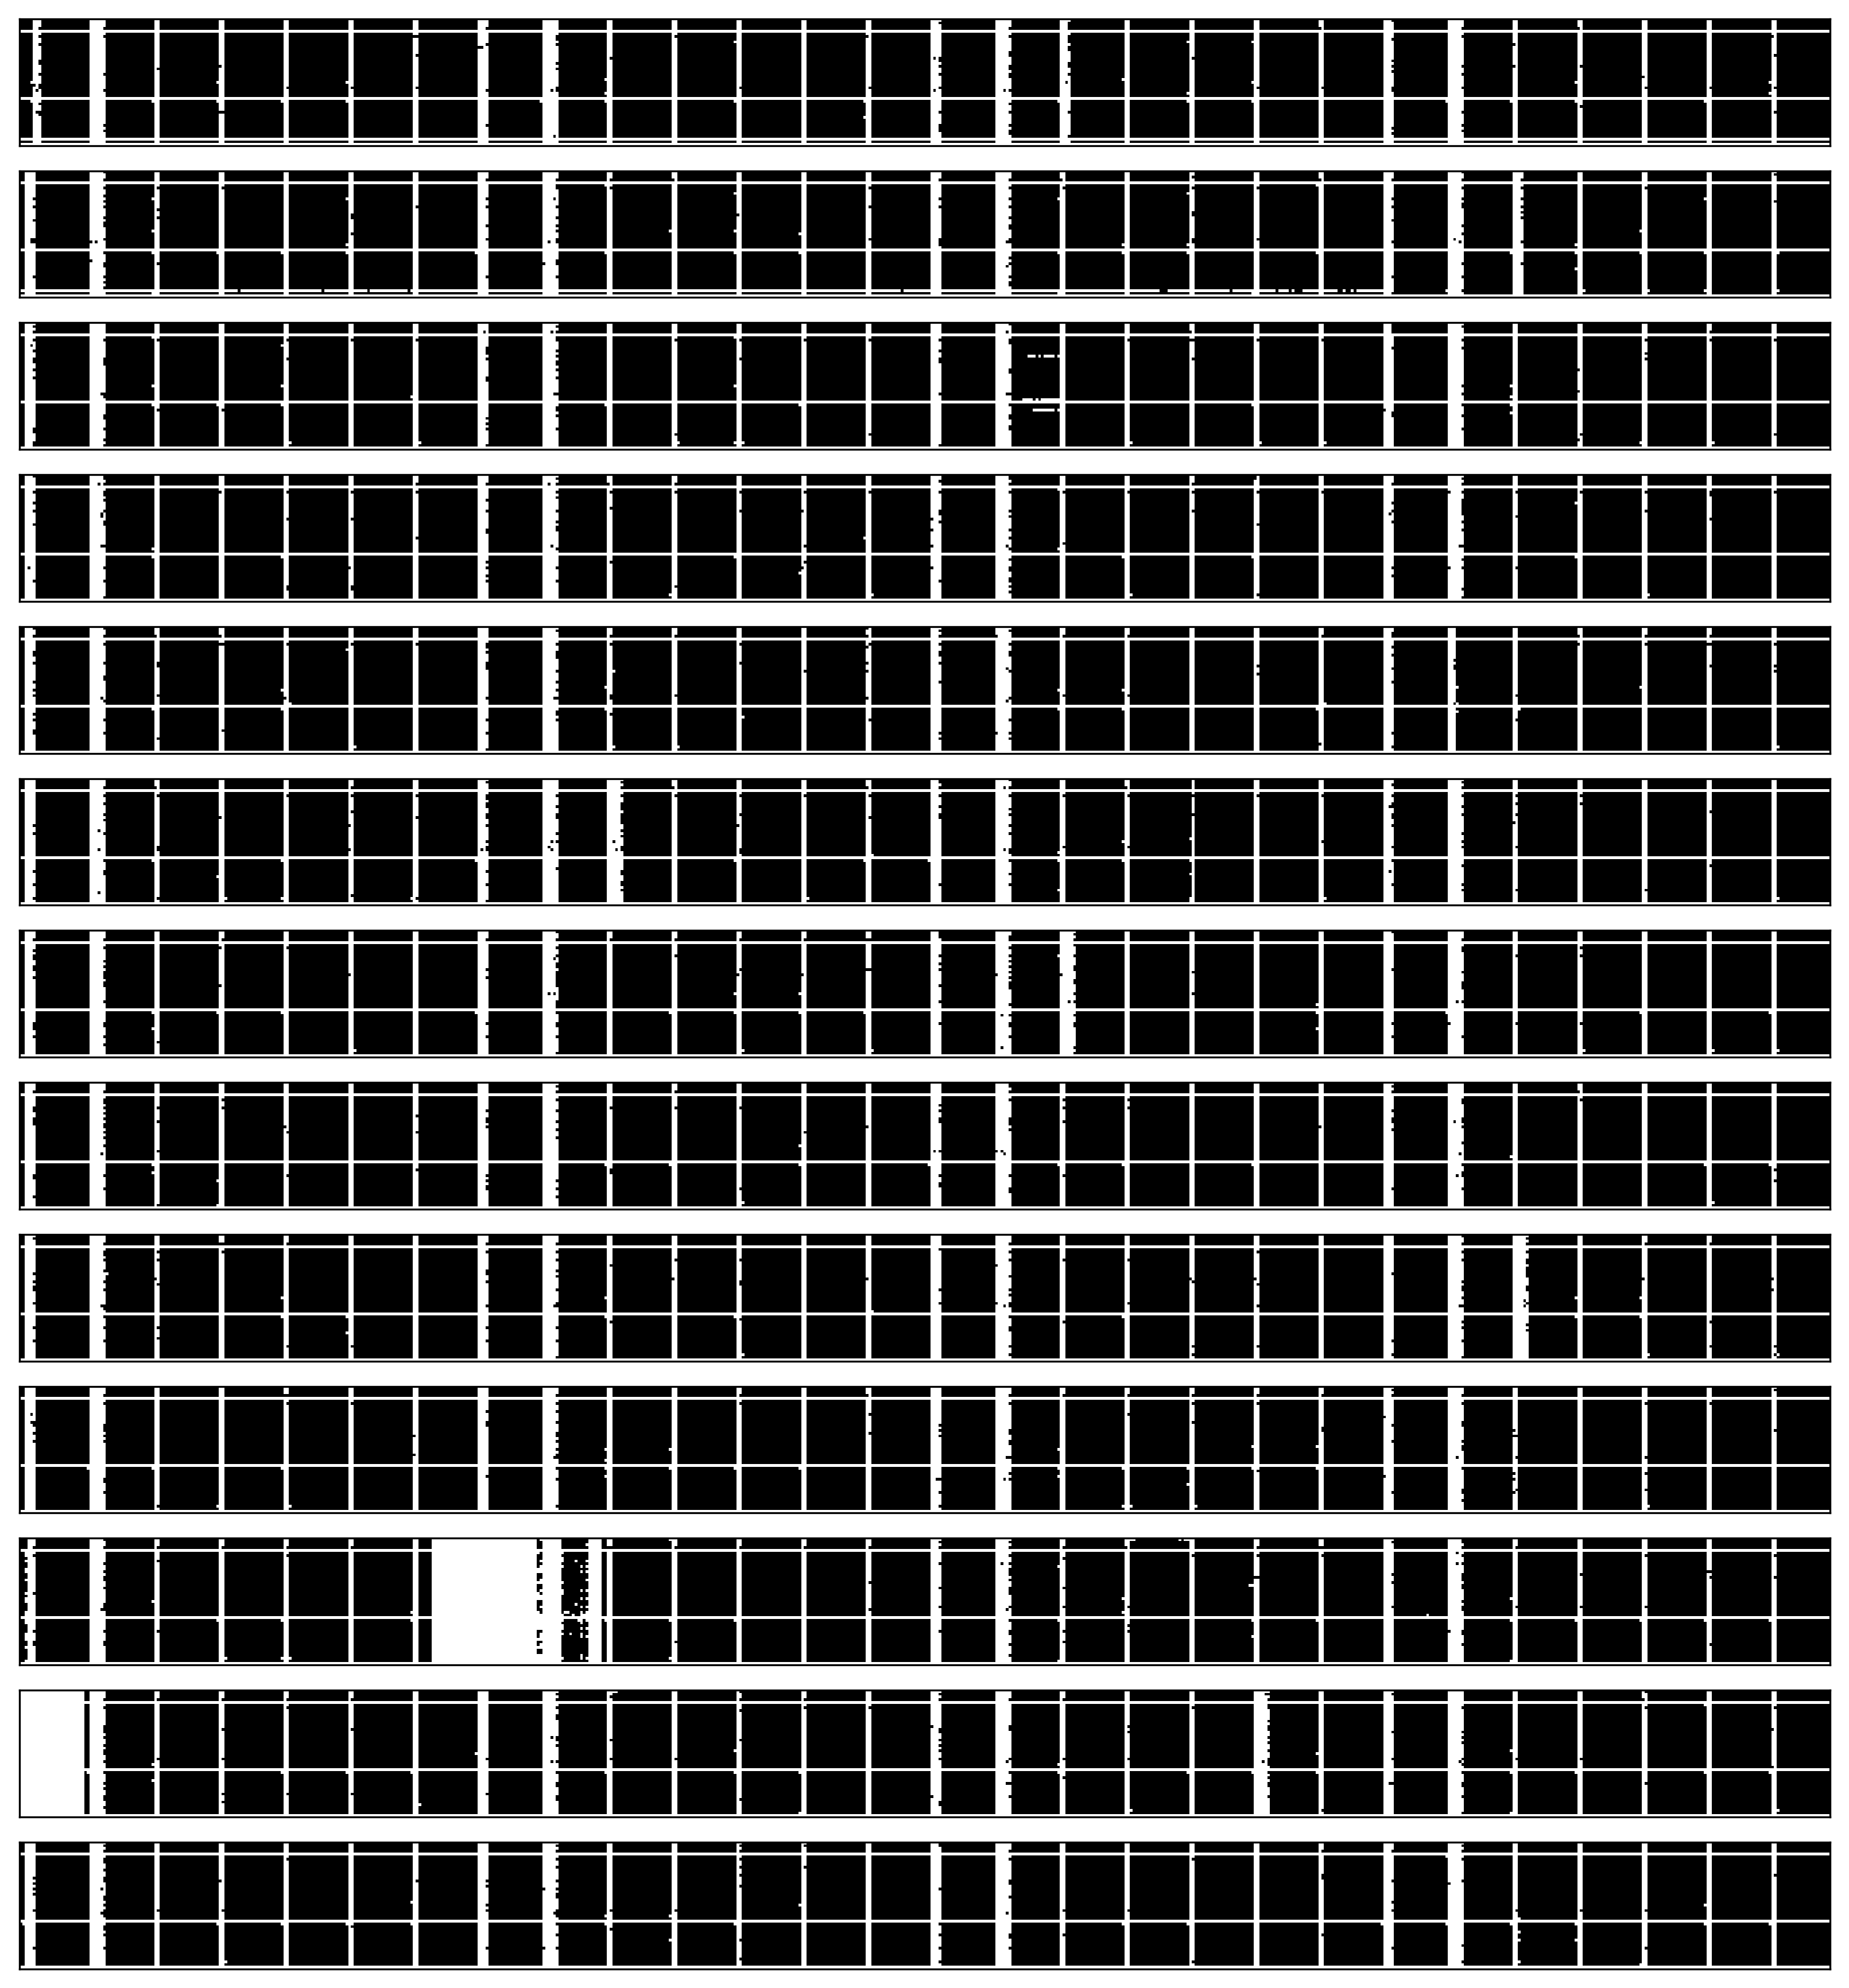

In [8]:
pyplot.figure(figsize=(14,3), dpi=300)
S = control.shape[0]
T = 13
N = 4
stacked = control[:, :T * 24 * 7 * N] \
    .reshape(S, T, 24 * 7 * N) \
    .transpose(0, 1)
pyplot.figure(figsize=(14,15), dpi=300)
for i, interval in enumerate(stacked):
    pyplot.subplot(T, 1, 1 + i)
    pyplot.imshow(interval, cmap="binary")
    pyplot.yticks([]); pyplot.xticks([]);